In [54]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
import torch
from torch import nn
import torch
from torch import nn
from torch.nn import LeakyReLU
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
loss_func = torch.nn.MSELoss()
leaky = LeakyReLU(0.1)
drop = torch.nn.Dropout(p=0.4)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [56]:
class aggregator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(aggregator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        #self.wei = torch.nn.Embedding(self.input_dim,self.output_dim)
        #self.bias = torch.nn.Embedding(1,self.output_dim)

    def forward(self, user, to_agg, rel):
        '''
        user: 128 * 64
        rel: 64 * 5
        to_agg: 128 * 5 * 64
        '''
        scores = torch.matmul(user, rel) # 128 * 5
        scores = leaky(scores)
        m = torch.nn.Softmax(dim=1) # 128 * 5
        scores = m(scores) # 128 * 5
        scores1 = scores.unsqueeze(1) #128 * 1 * 5
        context_agg = torch.bmm(scores1, to_agg) # 128 * 1 * 64
        return scores,context_agg



class context_aware_knowledge(nn.Module):
    def __init__(self, n_users, n_contexts, n_rc, n_entity, n_kc, n_factors,context_or):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.context_factors = torch.nn.Embedding(n_contexts, n_factors)
        self.relation_c = torch.nn.Embedding(n_factors, n_rc)
        self.entity_factors = torch.nn.Embedding(n_entity, n_factors)
        self.relation_k = torch.nn.Embedding(n_factors, n_kc) # 64 * 5
        self.agg = aggregator(n_factors, n_factors)
        self.context_or = context_or

    def forward(self, user, item, contexts_index, entities_index):

        entities = self.entity_factors(entities_index)  # 128 * 5 * 64
        contexts = self.context_factors(contexts_index)  # 128 * 5 * 64
        if self.context_or == True:
            importance_c, u_nei = self.agg(self.user_factors(user), contexts,
                    self.relation_c.weight)  # 128 * 1 * 64
            u_final = u_nei + self.user_factors(user).unsqueeze(1) # 128 * 1 * 64
            u_final = leaky(u_final)
        else:
            u_final = self.user_factors(user)
        importances = torch.matmul(u_final.squeeze(1), self.relation_k.weight) # 128 * 5
        importances = leaky(importances)
        m = torch.nn.Softmax(dim=1) # 128 * 5
        importances = m(importances) # 128 * 5
        scores = torch.bmm(entities,u_final.squeeze(1).unsqueeze(2)) # 128 * 5 * 1
        scores_final = torch.bmm(importances.unsqueeze(1),scores) # 128 * 1 * 1
        scores_final = scores_final.squeeze(2) # 128 * 1
        scores_final = scores_final.squeeze(1) # 128,
#         scores_final = scores.sum(1) / 5
#         scores_final = scores_final.squeeze(1)
        return scores_final,importances,scores,importance_c
    
    

In [57]:
meta_app_knowledge = pd.read_csv('/content/gdrive/My Drive/Colab/recsys 2023/data_yelp/df_business.csv')

n_entities = max(meta_app_knowledge['att1']) + 1
n_rel = meta_app_knowledge.shape[1] - 1
df = pd.read_csv('/content/gdrive/My Drive/Colab/recsys 2023/data_yelp/df_usable.csv')
n_cf = df.shape[1] - 3  # Here, we compute the number of contextual factors
# Here, we compute the number of users
n_users = len(df['user'].value_counts())
# Here, we compute the number of items
n_items = len(df['item'].value_counts())
n_contexts = max(df['Alone_Companion']) + 1

df_test = pd.read_csv('/content/gdrive/My Drive/Colab/recsys 2023/data_yelp/test.csv')

In [58]:
path = '/content/gdrive/My Drive/Colab/recsys 2023/3003/model0.05_16_0.001_4096.pkl'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_fata = context_aware_knowledge(n_users, n_contexts, n_cf, n_entities, n_rel,16,True).to(DEVICE)
load_params = torch.load(path,map_location=torch.device('cpu'))['model']
model_params = model_fata.state_dict()
same_parsms = {k: v for k, v in load_params.items()
               if k in model_params.keys()}
model_params.update(same_parsms)

model_fata.load_state_dict(model_params)

<All keys matched successfully>

In [59]:
def RMSE(data, model,meta_app_knowledge):
    model.eval()
    contexts_index = data.iloc[:, 3:].values
    contexts_index = torch.tensor(contexts_index).to(DEVICE)
    item = data['item'].values
    entities_index = meta_app_knowledge.loc[item].iloc[:, 1:].values
    entities_index = torch.tensor(entities_index).to(DEVICE)

    rating = torch.FloatTensor(data['cnt'].values).to(DEVICE)
    user = torch.LongTensor(data['user'].values).to(DEVICE)
    item = torch.LongTensor(data['item'].values).to(DEVICE)
    #rating = (rating + 1) * 2 + 1
    #rating = rating * 4.458668059764898 / 5
    # Predict and calculate loss
    prediction,importances,scores,importance_c = model(user, item, contexts_index, entities_index)
    #prediction = (prediction + 1) * 2 + 1
    #prediction = prediction * 4.458668059764898 / 5
    rating = rating.cpu().detach()
    prediction = prediction.cpu().detach()
    rmse = loss_func(prediction, rating)
    mae = torch.nn.L1Loss()(prediction, rating)
    return  torch.sqrt(rmse), mae,importances,scores,importance_c

In [60]:
rmse, mae,importances,scores,importance_c = RMSE(df_test, model_fata,meta_app_knowledge)

In [61]:
test = df_test.copy()
index_user = test.drop_duplicates(subset = ['user'],keep = 'first').index.values

In [62]:
rmse, mae,importance_c.shape

(tensor(1.1047), tensor(0.8513), torch.Size([20702, 8]))

In [63]:
for i in range(8):
    print(importance_c[:,i].mean())

tensor(0.1222, grad_fn=<MeanBackward0>)
tensor(0.1220, grad_fn=<MeanBackward0>)
tensor(0.1246, grad_fn=<MeanBackward0>)
tensor(0.1223, grad_fn=<MeanBackward0>)
tensor(0.1233, grad_fn=<MeanBackward0>)
tensor(0.1261, grad_fn=<MeanBackward0>)
tensor(0.1297, grad_fn=<MeanBackward0>)
tensor(0.1297, grad_fn=<MeanBackward0>)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:1366

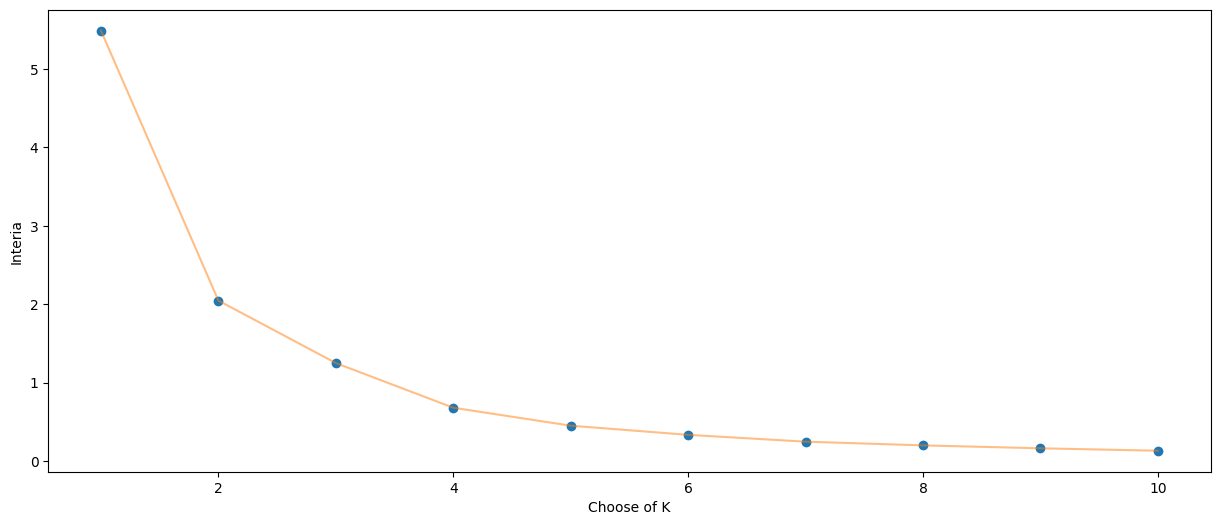

In [64]:
from sklearn.cluster import KMeans
X = importance_c[index_user].detach().numpy()
df_empty = pd.DataFrame(columns=['first','second','third','forth','fifth','sixth','seventh','eigth','label'])
df_empty['first'] = X[:,0]
df_empty['second'] = X[:,1]
df_empty['third'] = X[:,2]
df_empty['forth'] = X[:,3]
df_empty['fifth'] = X[:,4]
df_empty['sixth'] = X[:,5]
df_empty['seventh'] = X[:,6]
df_empty['eigth'] = X[:,7]
df1 = df_empty[['first','second','third','forth','fifth','sixth','seventh','eigth']].iloc[:,:].values  
inertia = []   

for k in range(1,11):  
    algorithm = (KMeans(n_clusters=k,  
                       init="k-means++",  
                       n_init=10,  
                       max_iter=300,  
                       tol=0.0001,  
                       random_state=111,  
                       algorithm="full"))  
    algorithm.fit(df1)  
    inertia.append(algorithm.inertia_) 
plt.figure(1,figsize=(15,6))
plt.plot(np.arange(1,11), inertia, 'o')  
plt.plot(np.arange(1,11), inertia, '-', alpha=0.5)

plt.xlabel("Choose of K")
plt.ylabel("Interia")
plt.show()

In [85]:
n_clusters = 3
estimators = KMeans(n_clusters=n_clusters)
estimators.fit(X)
labele = estimators.labels_
df_empty['label'] = labele

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster: 0 0.12375166 0.12353274 0.1269455 0.12361018 0.12295756 0.12283083 0.12265563 0.1337159


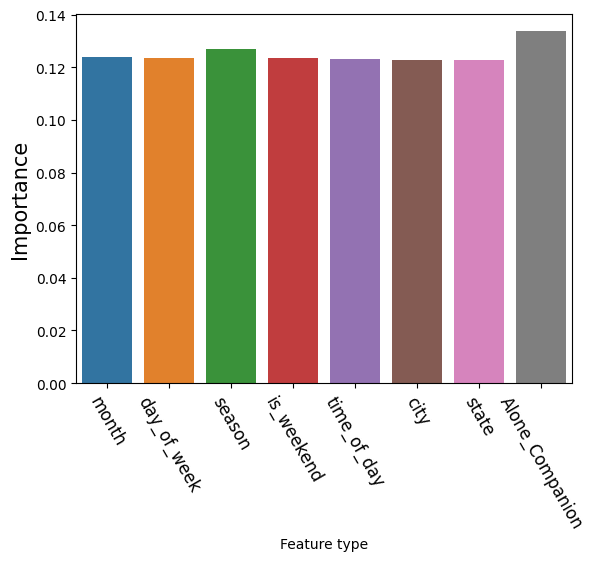

Cluster: 1 0.11755278 0.11777592 0.118050784 0.11860192 0.1251397 0.1360592 0.14924689 0.117572814


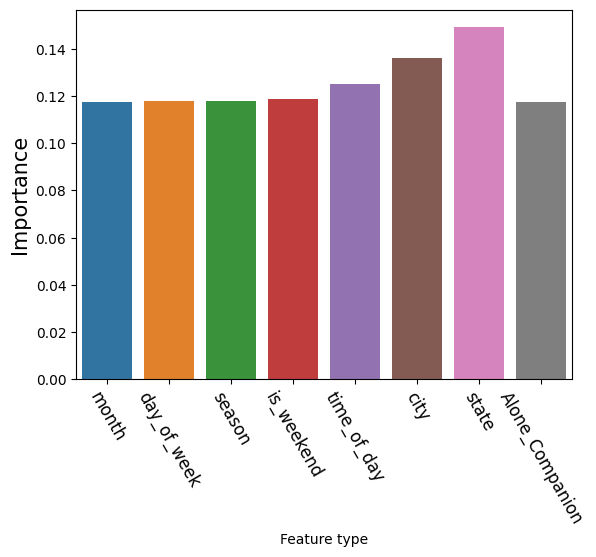

Cluster: 2 0.10523644 0.10575388 0.106534496 0.107114896 0.123456284 0.15272035 0.1935922 0.10559146


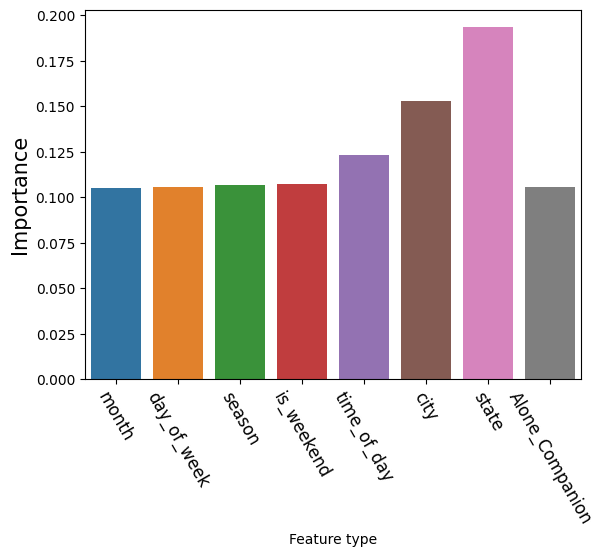

In [86]:
import seaborn as sns
for i in range(n_clusters):
    print("Cluster:", i, df_empty[df_empty['label'] == i]['first'].mean(),df_empty[df_empty['label'] == i]['second'].mean(),df_empty[df_empty['label'] == i]['third'].mean(),df_empty[df_empty['label'] == i]['forth'].mean(),df_empty[df_empty['label'] == i]['fifth'].mean(),df_empty[df_empty['label'] == i]['sixth'].mean(),df_empty[df_empty['label'] == i]['seventh'].mean(),df_empty[df_empty['label'] == i]['eigth'].mean())
    import matplotlib.pyplot as plt
    plt.xlabel('Feature type')
    plt.ylabel('Importance',fontsize=15)
    name_list = df_test.columns[3:]
    num_list = [df_empty[df_empty['label'] == i]['first'].mean(),df_empty[df_empty['label'] == i]['second'].mean(),df_empty[df_empty['label'] == i]['third'].mean(),df_empty[df_empty['label'] == i]['forth'].mean(),df_empty[df_empty['label'] == i]['fifth'].mean(),df_empty[df_empty['label'] == i]['sixth'].mean(),df_empty[df_empty['label'] == i]['seventh'].mean(),df_empty[df_empty['label'] == i]['eigth'].mean()]

    hist_fig = sns.barplot(x = name_list, y = num_list,tick_label=name_list)
    plt.xticks(fontsize  = 'large',rotation=-60) 
    #plt.savefig('/home/jinfeng/Downloads/doctorant/Conférences/dsaa/argumrntative/test2.png')

    plt.show()

In [122]:
#labele = yhat
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
data, label,title = X, labele,'Cluster of users according to importances of contexts'
print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0,perplexity=50)

result = ts.fit_transform(data)

# x_min, x_max = np.min(result, 0), np.max(result, 0)
# result = (result - x_min) / (x_max - x_min)

Starting compute t-SNE Embedding...


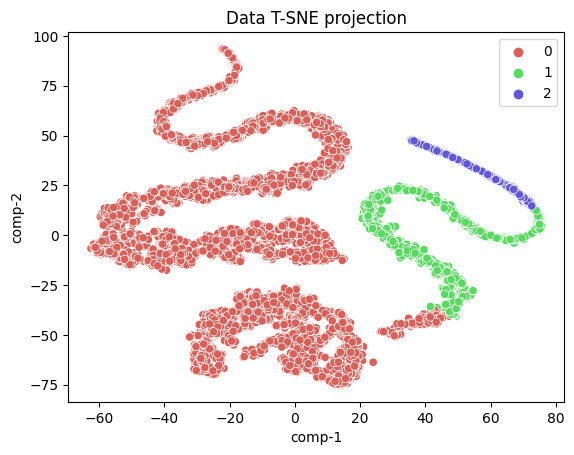

In [123]:
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = result[:,0]
df["comp-2"] = result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="Data T-SNE projection")
plt.show()

In [124]:
# !pip3 install umap-learn

In [125]:
# !pip install "umap-learn[plot]"

In [126]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
from umap import UMAP
import umap.umap_ as umap
import umap.plot
import umap

In [127]:
# reslut = UMAP().fit_transform(X)

# # x_min, x_max = np.min(reslut, 0), np.max(reslut, 0)
# # reslut = (reslut - x_min) / (x_max - x_min)

In [141]:
# import seaborn as sns
# df = pd.DataFrame()
# df["y"] = labele
# df["comp-1"] = reslut[:,0]
# df["comp-2"] = reslut[:,1]

# sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
#                 palette=sns.color_palette("hls", n_clusters),
#                 data=df).set(title="Data UMAP projection")
# plt.show()

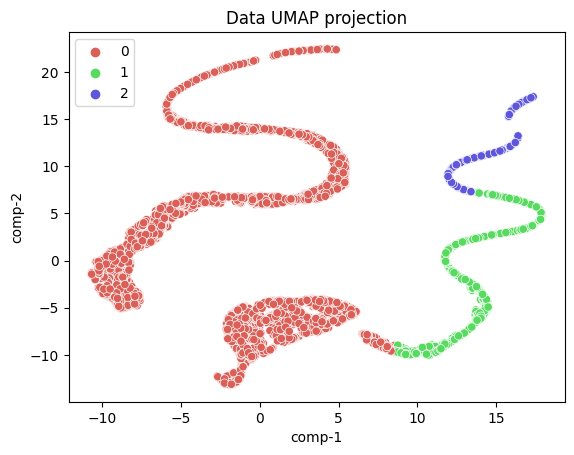

In [129]:
reducer = umap.UMAP(random_state=42)
reducer.fit(X)
embedding = reducer.transform(X)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = embedding[:,0]
df["comp-2"] = embedding[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="Data UMAP projection")
plt.show()

/usr/local/lib/python3.9/dist-packages/umap/plot.py:448: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

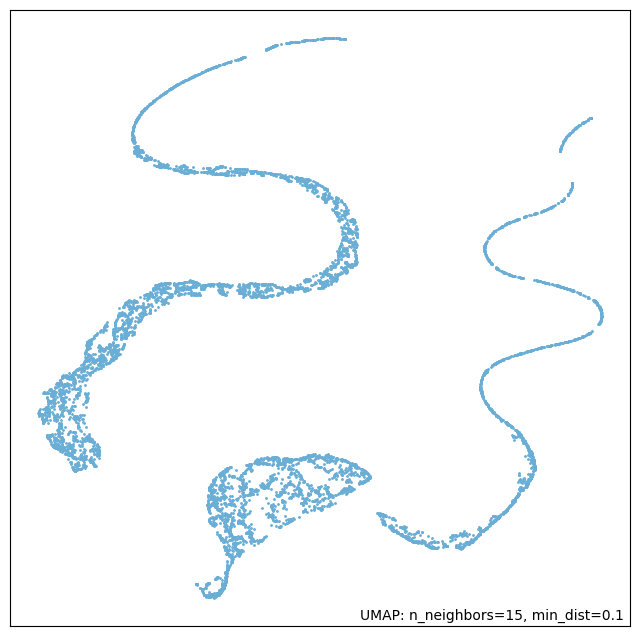

In [130]:
umap.plot.points(reducer)

<Axes: >

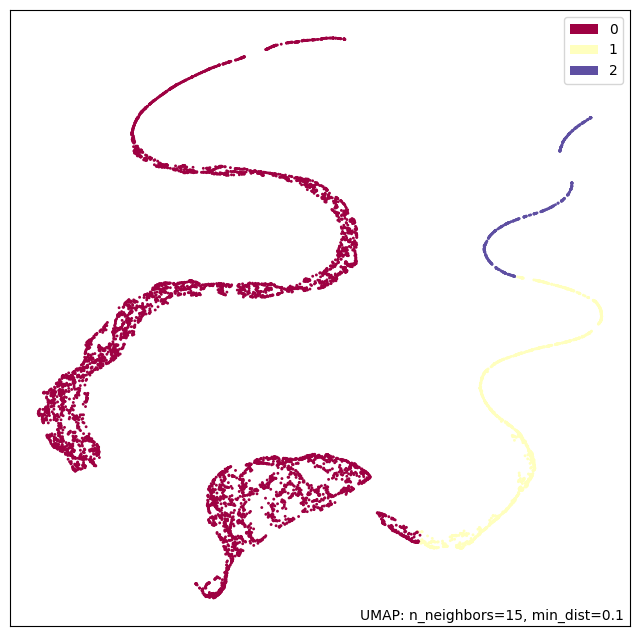

In [131]:
umap.plot.points(reducer, labels=labele)

<Axes: >

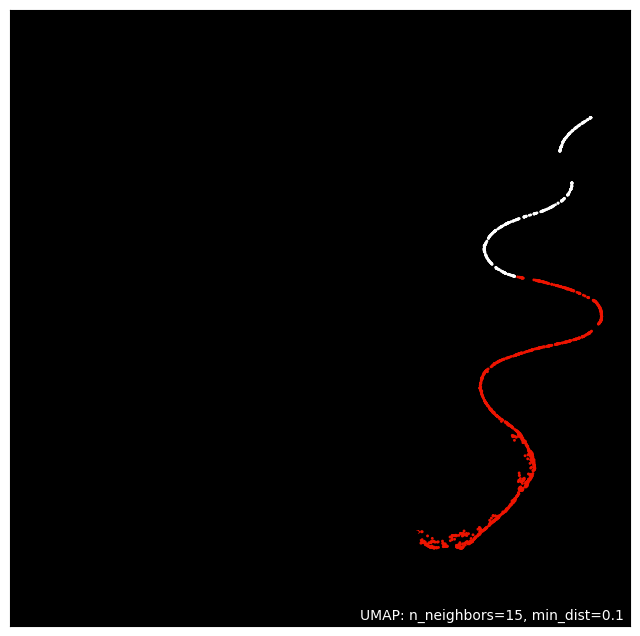

In [132]:
umap.plot.points(reducer, values=labele, theme='fire')

<Axes: >

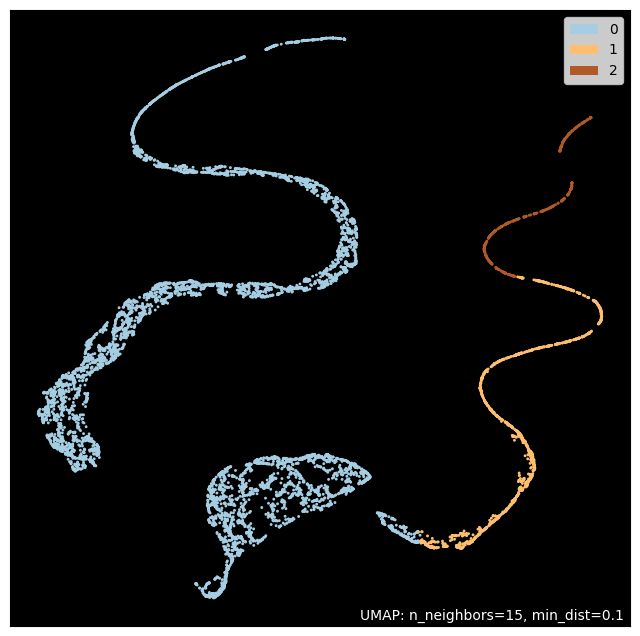

In [133]:
umap.plot.points(reducer, labels=labele, color_key_cmap='Paired', background='black')

<Axes: >

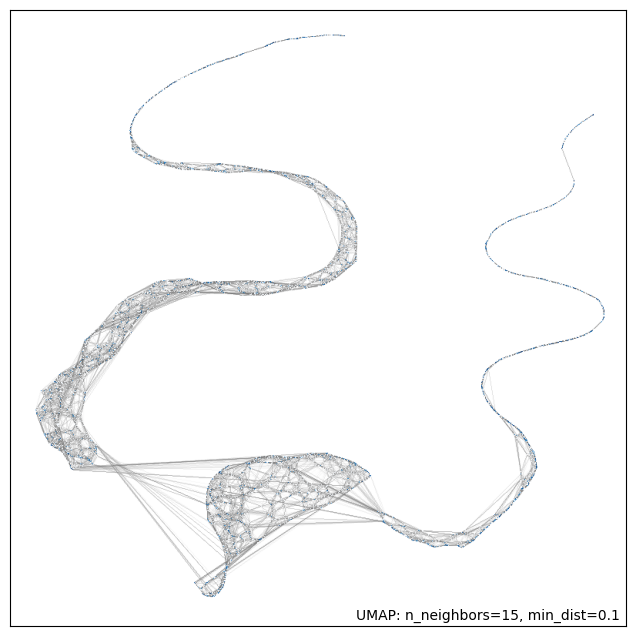

In [134]:
umap.plot.connectivity(reducer, show_points=True)

/usr/local/lib/python3.9/dist-packages/umap/plot.py:885: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<Axes: >

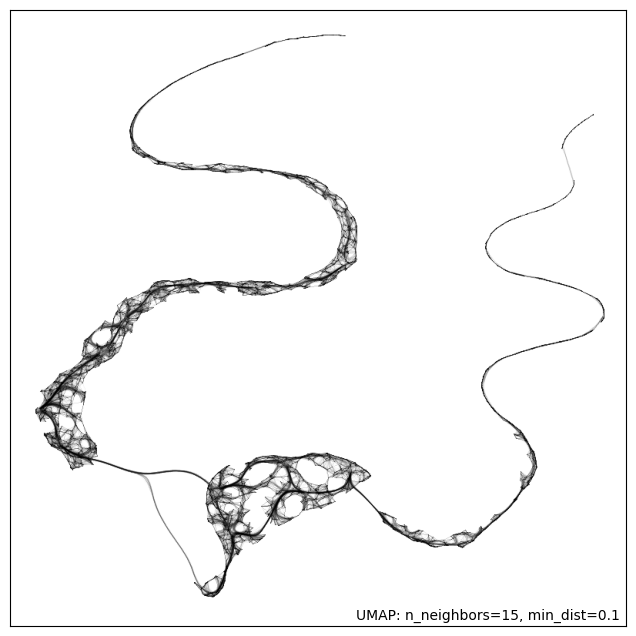

In [135]:
umap.plot.connectivity(reducer, edge_bundling='hammer')

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

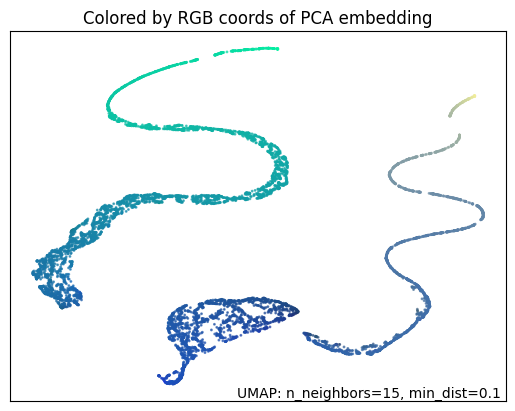

In [136]:
umap.plot.diagnostic(reducer, diagnostic_type='pca')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: title={'center': 'Colored by RGB coords of Vector Quantization'}>

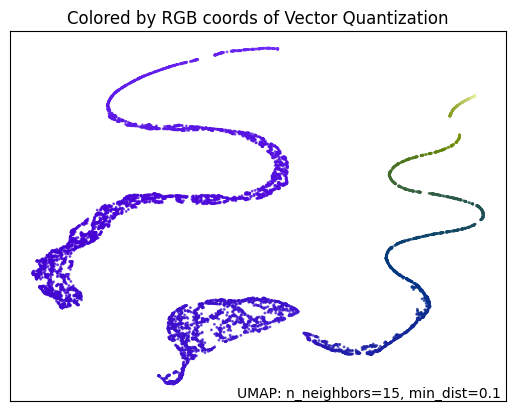

In [137]:
umap.plot.diagnostic(reducer, diagnostic_type='vq')

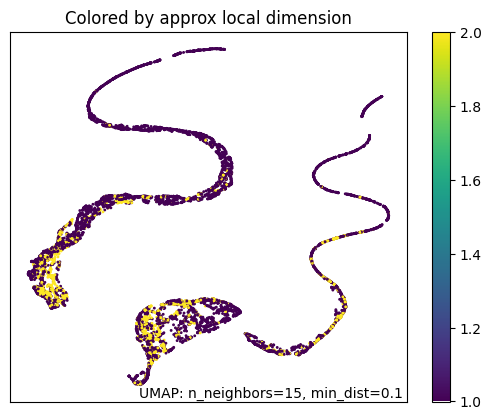

In [138]:
local_dims = umap.plot.diagnostic(reducer, diagnostic_type='local_dim')

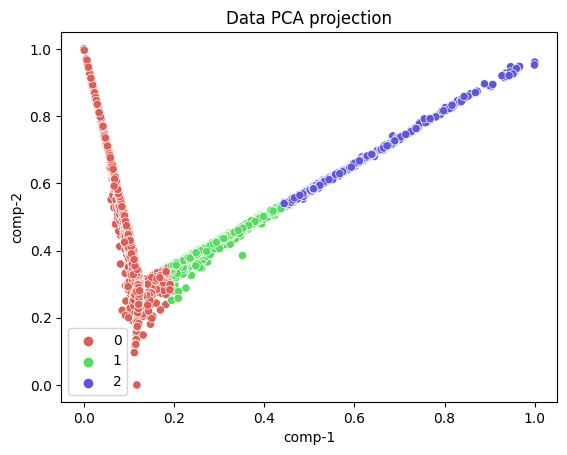

In [139]:
from sklearn.decomposition import PCA
result = PCA(n_components=2).fit_transform(data)
x_min, x_max = np.min(result, 0), np.max(result, 0)
result = (result - x_min) / (x_max - x_min)
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = result[:,0]
df["comp-2"] = result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="Data PCA projection")
#plt.savefig('cluster_pca.png')
plt.show()


In [140]:
hover_data = pd.DataFrame({'index':np.arange(8034),
                           'label':df_empty.label[:8034]})
hover_data['item'] = hover_data.label
umap.plot.output_notebook()
p = umap.plot.interactive(reducer, labels=df_empty.label[:8034], hover_data=hover_data, point_size=2)
umap.plot.show(p)